Installing necessary python packages:


In [1]:
# !pip install torch torchvision torchaudio
!pip install scapy
!pip install flask
!pip install flask_ngrok

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 23.2 MB/s eta 0:00:00


Necessary imports for model manipulation & Flask app deployment:

---



In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torch
from scapy.all import *
import os
import matplotlib.pyplot as plt
from flask import Flask, render_template, request, redirect, url_for, send_file, render_template_string
from werkzeug.utils import secure_filename
from io import BytesIO
import base64

c:\Users\Techistan\.conda\envs\f5-tts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The model has 24 output classes:


In [3]:
classes = [
 'Analysis',
 'Backdoor',
 'Bot',
 'DDoS',
 'DoS',
 'DoS GoldenEye',
 'DoS Hulk',
 'DoS SlowHTTPTest',
 'DoS Slowloris',
 'Exploits',
 'FTP Patator',
 'Fuzzers',
 'Generic',
 'Heartbleed',
 'Infiltration',
 'Normal',
 'Port Scan',
 'Reconnaissance',
 'SSH Patator',
 'Shellcode',
 'Web Attack - Brute Force',
 'Web Attack - SQL Injection',
 'Web Attack - XSS',
 'Worms']

print(len(classes))


24


We retrieve the model we are using from HugginFace, the model employs the BERT model fine-tuned for classifying network packet flow based on header and payload information.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("mwz/NID_tr")
model = AutoModelForSequenceClassification.from_pretrained("mwz/NID_tr")

 Details and architecture of the pre-trained BERT model.

In [5]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


nput embeddings of the pre-trained BERT model previously loaded.

In [6]:
print(model.get_input_embeddings())

Embedding(28996, 768, padding_idx=0)


Configuration settings of the pre-trained BERT model, revealing details such as model architecture, hyperparameters, and other configuration parameters.

In [7]:
print(model.config)

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "mwz/NID_tr",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Analysis",
    "1": "Backdoor",
    "2": "Bot",
    "3": "DDoS",
    "4": "DoS",
    "5": "DoS GoldenEye",
    "6": "DoS Hulk",
    "7": "DoS SlowHTTPTest",
    "8": "DoS Slowloris",
    "9": "Exploits",
    "10": "FTP Patator",
    "11": "Fuzzers",
    "12": "Generic",
    "13": "Heartbleed",
    "14": "Infiltration",
    "15": "Normal",
    "16": "Port Scan",
    "17": "Reconnaissance",
    "18": "SSH Patator",
    "19": "Shellcode",
    "20": "Web Attack - Brute Force",
    "21": "Web Attack - SQL Injection",
    "22": "Web Attack - XSS",
    "23": "Worms"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Analysis": 0,
    "Backdoor": 1,
    "Bot": 2,
    "DDoS": 3,
    "DoS": 4,
    "DoS Go

Information about the tokenizer and the model input names. The first line prints details about the tokenizer, while the second line displays the input names expected by the model according to the tokenizer.

In [8]:
print(tokenizer)
print(tokenizer.model_input_names)

DistilBertTokenizerFast(name_or_path='mwz/NID_tr', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
['input_ids', 'attention_mask']


`processing_packet_conversion` performs packet decimal conversion and aditionnal changes to fit the input structure of the model representing a packet, The following diagram shows the structure to be respected:

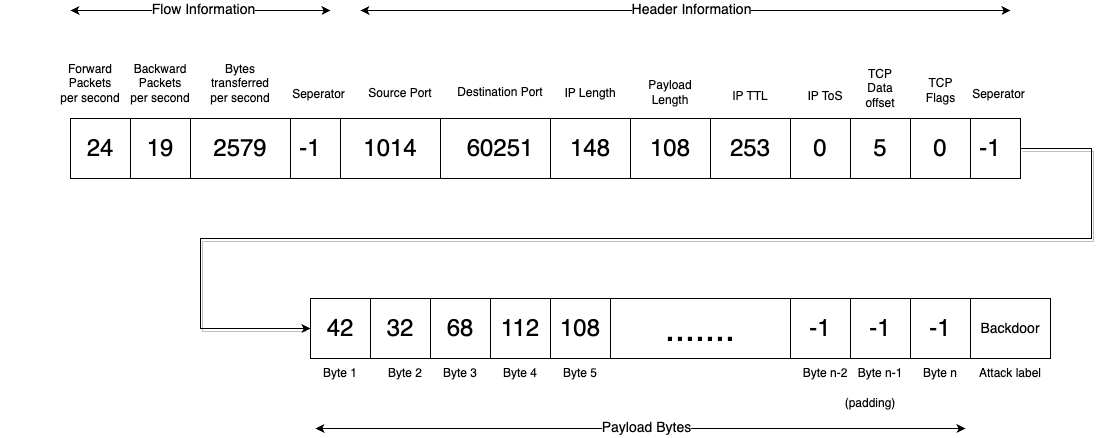

In [10]:
# Initialize dictionaries and lists for packet analysis.
packets_brief = {}
forward_packets = {}
backward_packets = {}
protocols = []
protocol_counts = {}

def processing_packet_conversion(packet):
    # Clone the packet for processing without modifying the original.
    packet_2 = packet

    while packet_2:
        # Extract and count protocol layers in the packet.
        layer = packet_2[0]
        if layer.name not in protocol_counts:
            protocol_counts[layer.name] = 0
        else:
            protocol_counts[layer.name] += 1
        protocols.append(layer.name)

        # Break if there are no more payload layers.
        if not layer.payload:
            break
        packet_2 = layer.payload

    # Extract relevant information for feature creation.
    src_ip = packet[IP].src
    dst_ip = packet[IP].dst
    src_port = packet.sport
    dst_port = packet.dport
    ip_length = len(packet[IP])
    ip_ttl = packet[IP].ttl
    ip_tos = packet[IP].tos
    tcp_data_offset = packet[TCP].dataofs
    tcp_flags = packet[TCP].flags

    # Process payload content and create a feature string.
    payload_bytes = bytes(packet.payload)
    payload_length = len(payload_bytes)
    payload_content = payload_bytes.decode('utf-8', 'replace')
    payload_decimal = ' '.join(str(byte) for byte in payload_bytes)
    final_data = "0" + " " + "0" + " " + "195" + " " + "-1" + " " + str(src_port) + " " + str(dst_port) + " " + str(ip_length) + " " + str(payload_length) + " " + str(ip_ttl) + " " + str(ip_tos) + " " + str(tcp_data_offset) + " " + str(int(tcp_flags)) + " " + "-1" + " " + str(payload_decimal)
    return final_data


Generate a graph giving an overview of the predictions that have been made.

The `trainFromPcapFile` function processes network packets from a pcap file, extracts relevant features, tokenizes the input using a specified tokenizer, and utilizes a pre-trained model for classifying packet content. It prints predictions and probabilities for non-normal packet classes, updating a dictionary with counts for each identified attack type. The function also tracks the total number of processed packets.


In [11]:
def trainFromPcapFile(file_path, label, application_filter):

    training_set = []
    train_labels = []

    with PcapReader(file_path) as pcap:
        for pkt in pcap:
            if IP in pkt and TCP in pkt:  # IPv4 and TCP
                payload_bytes_to_filter = bytes(pkt.payload)
                if application_filter is None or application_filter in payload_bytes_to_filter:
                  input_line = processing_packet_conversion(pkt)
                  if input_line is not None:
                      truncated_line = input_line[:1024]
                      training_set.append(truncated_line)
                      train_labels.append(label)

    tokenized_input = tokenizer(training_set, padding=True, truncation=True, return_tensors="pt")
    tokenized_input['labels'] = torch.tensor(train_labels)

    # Move input tensors to the specified device
    tokenized_input = {key: value.to(device) for key, value in tokenized_input.items()}

    # Data loader
    dataset = TensorDataset(tokenized_input["input_ids"], tokenized_input["attention_mask"], tokenized_input["labels"])
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    num_training_samples = len(dataloader.dataset)
    print(f"Number of training samples: {num_training_samples}")

    # Optimizer and loss function
    optimizer = Adam(model.parameters(), lr=1e-5)
    criterion = CrossEntropyLoss()

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for iteration, batch in enumerate(dataloader, 1):
            input_ids, attention_mask, labels = batch

            # Move batch tensors to the specified device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            print(f"Total samples: {total_samples}")

        model.save_pretrained("fine_tuned_model")

# trainFromPcapFile("/content/sample_data/nmap.pcap", 16) # Port scanning
# trainFromPcapFile("/content/sample_data/portscan.pcap", 16) # Port scanning
# trainFromPcapFile("/content/sample_data/hulk.pcap", 6) # Hulk
# trainFromPcapFile("/content/sample_data/dvwa_sql_injection.pcap.pcapng", 21, b"GET /")


The `predictingRowsCategory` function reads packets from a pcap file, processes IPv4 and TCP packets, extracts features, tokenizes them using a specified tokenizer, and predicts their class using a pre-trained model. If the predicted class is a non-normal packet, it updates a dictionary with counts for each identified attack type. Prediction details are printed, and the total number of processed packets is tracked. The processed packets' textual representations are stored in the `text_data` list.

In [12]:
text_data = []

def predictingRowsCategory(file_path, filter):
  packets_nbr = 0  # Initialize packet counter
  with PcapReader(file_path) as pcap:
    for pkt in pcap :
      if IP in pkt :  # Check for IPv4 packets
        if TCP in pkt:

          input_line = processing_packet_conversion(pkt)  # Process packet data
          if input_line is not None:

            truncated_line = input_line[:1024]  # Limit input length
            tokens = tokenizer(truncated_line, return_tensors="pt")  # Tokenize input
            outputs = model(**tokens)  # Pass tokens through the model
            logits = outputs.logits
            probabilities = logits.softmax(dim=1)  # Calculate class probabilities
            predicted_class = torch.argmax(probabilities, dim=1).item()  # Get predicted class index

            predictedAttack = classes[predicted_class]  # Map index to corresponding attack class

            if predictedAttack != "Normal":
              # Update or add count for non-normal packets in packets_brief dictionary
              if predictedAttack not in packets_brief :
                packets_brief[predictedAttack] = 1
              else :
                packets_brief[predictedAttack] += 1

            # Print prediction details
            print("Predicted class:", predicted_class)
            print("predicted class is : ", classes[predicted_class])
            print("Class probabilities:", probabilities.tolist())

          packets_nbr += 1  # Increment packet counter


Predictions test

Predicted class: 15
predicted class is :  Normal
Class probabilities: [[1.45956424030258e-11, 3.044070898128304e-11, 1.3210879501457384e-08, 9.917354191202321e-07, 9.19772205065783e-08, 4.465851333179671e-08, 4.927526333631249e-06, 4.5720807406723907e-07, 6.29685104058808e-08, 1.9220431468625065e-08, 1.641270159780106e-07, 1.9661132444337426e-10, 1.1703476410218627e-08, 2.6323682789097802e-08, 5.170051498026851e-09, 0.9999886751174927, 3.0264182271366735e-08, 3.1376837239527333e-10, 3.565903625712963e-06, 1.527461317152312e-11, 8.039693852879282e-07, 1.109373370944411e-09, 1.254048243026773e-07, 4.768216932404812e-10]]
Predicted class: 15
predicted class is :  Normal
Class probabilities: [[1.3644067646534364e-11, 2.8840504637250852e-11, 1.3964212897121797e-08, 5.286733539833222e-07, 1.0212973222678556e-07, 3.329838094145998e-08, 5.036279617343098e-06, 2.339909741522206e-07, 5.893400611967081e-08, 2.301624490996801e-08, 9.932323052908032e-08, 1.8043909422171822e-10, 1.6514702494418998e-

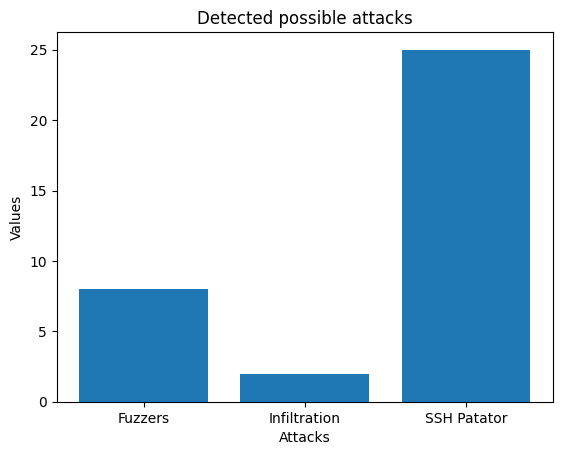

In [14]:
predictingRowsCategory("./test_file.pcap", b"HTTP")

import matplotlib.pyplot as plt

keys = list(packets_brief.keys())
vals = list(packets_brief.values())

plt.bar(keys, vals)

plt.xlabel('Attacks')
plt.ylabel('Values')
plt.title('Detected possible attacks')
plt.show()

We specify to Pytorch that we wish to prioritize training on GPU and not on CPU.

In [15]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
model = model.to(device)

NVIDIA GeForce RTX 4090


In [16]:
# Initialize an empty list to store textual data.
text_data = []

# Function for predicting packet categories on GPU and updating briefs.
def predictingRowsCategoryOnGPU(file_path, filter, debug):
    packets_brief.clear()  # Clear the dictionary tracking packet briefs.

    packets_nbr = 0  # Initialize packet counter.
    with PcapReader(file_path) as pcap:  # Iterate through packets in the pcap file.
        for pkt in pcap:
            if IP in pkt:  # Check for IPv4 packets.
                if TCP in pkt:  # Ensure the packet is TCP.

                    # Filter packets based on payload content.
                    payload_bytes_to_filter = bytes(pkt.payload)
                    if filter in payload_bytes_to_filter:

                        # Process and truncate packet data.
                        input_line = processing_packet_conversion(pkt)
                        if input_line is not None:
                            truncated_line = input_line[:1024]

                            # Tokenize the truncated input and move it to the specified device.
                            tokens = tokenizer(truncated_line, return_tensors="pt")
                            tokens = {key: value.to(device) for key, value in tokens.items()}

                            # Pass tokens through the pre-trained model for prediction.
                            outputs = model(**tokens)

                            logits = outputs.logits
                            probabilities = logits.softmax(dim=1)
                            predicted_class = torch.argmax(probabilities, dim=1).item()

                            predictedAttack = classes[predicted_class]

                            # Update packet brief dictionary for non-normal packets.
                            if predictedAttack != "Normal":
                                if predictedAttack not in packets_brief:
                                    packets_brief[predictedAttack] = 1
                                else:
                                    packets_brief[predictedAttack] += 1

                            # Append truncated line to the textual data list.
                            text_data.append(truncated_line)

                            # Print prediction details when debugging is enabled.
                            if debug:
                                print("Predicted class:", predicted_class)
                                print("Predicted class is: ", classes[predicted_class])
                                print("Class probabilities:", probabilities.tolist())

                        packets_nbr += 1  # Increment packet counter.


 `predictingRowsCategoryOnGPUByGettingRidOfParameters` function processes network packets from a pcap file, filters based on specified criteria, modifies the input by excluding certain tokens, tokenizes the modified input using a pre-trained tokenizer on a GPU, and predicts the packet class using a pre-trained model. If the predicted class is non-normal, it updates a dictionary with counts for each identified attack type. Optionally, it prints prediction details when debugging is enabled. The total number of processed packets is tracked, and the resulting brief is stored in the packets_brief dictionary.

In [17]:
def predictingRowsCategoryOnGPUByGettingRidOfParameters(file_path, filter, debug, tokens_array):
    packets_brief.clear()  # Clear the dictionary tracking packet briefs.

    packets_nbr = 0  # Initialize packet counter.
    with PcapReader(file_path) as pcap:  # Iterate through packets in the pcap file.
        for pkt in pcap:
            if IP in pkt:  # Check for IPv4 packets.
                if TCP in pkt:  # Ensure the packet is TCP.
                    payload_bytes_to_filter = bytes(pkt.payload)
                    if filter in payload_bytes_to_filter:  # Apply payload filtering criteria.

                        # Process and truncate packet data.
                        input_line = processing_packet_conversion(pkt)
                        if input_line is not None:
                            truncated_line = input_line[:1024]

                            # Remove specified tokens from the truncated line.
                            tokens_to_exclude = tokens_array
                            tokens_list = truncated_line.split()
                            modified_tokens_list = [token for i, token in enumerate(tokens_list) if i not in tokens_to_exclude]
                            modified_truncated_line = ' '.join(modified_tokens_list)

                            # Tokenize the modified input and move it to the specified device.
                            tokens = tokenizer(modified_truncated_line, return_tensors="pt")
                            tokens = {key: value.to(device) for key, value in tokens.items()}

                            # Pass tokens through the pre-trained model.
                            outputs = model(**tokens)

                            # Extract prediction details.
                            logits = outputs.logits
                            probabilities = logits.softmax(dim=1)
                            predicted_class = torch.argmax(probabilities, dim=1).item()
                            predictedAttack = classes[predicted_class]

                            # Update packet brief dictionary for non-normal packets.
                            if predictedAttack != "Normal":
                                if predictedAttack not in packets_brief:
                                    packets_brief[predictedAttack] = 1
                                else:
                                    packets_brief[predictedAttack] += 1

                            # Print prediction details when debugging is enabled.
                            if debug:
                                print("Predicted class:", predicted_class)
                                print("Predicted class is: ", classes[predicted_class])
                                print("Class probabilities:", probabilities.tolist())

                        packets_nbr += 1  # Increment packet counter.


Predictions test on GPU

c:\Users\Techistan\.conda\envs\f5-tts\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


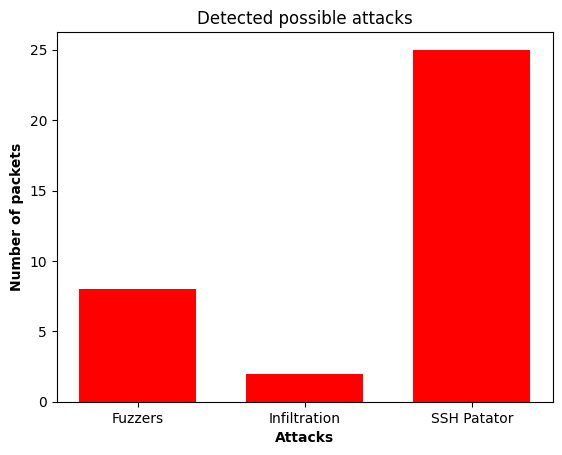

In [18]:
predictingRowsCategoryOnGPU("./test_file.pcap", b"", False)

keys = list(packets_brief.keys())
vals = list(packets_brief.values())

plt.bar(keys, vals, color='red', width=0.7)

plt.xlabel('Attacks', weight='bold')
plt.ylabel('Number of packets', weight='bold')
plt.title('Detected possible attacks')
plt.show()

Network-visualisation & graphs creating functions :

In [23]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from scapy.all import *

# def create_network_graph(pcap_file):
#     packets = rdpcap(pcap_file)
#     G = nx.DiGraph()
#     for packet in packets:
#         src_ip = packet[IP].src
#         dst_ip = packet[IP].dst
#         G.add_edge(src_ip, dst_ip)
#     return G

# def visualize_network_graph(pcap_file_path):

#     network_graph = create_network_graph(pcap_file_path)

#     pos = nx.spring_layout(network_graph)
#     nx.draw(network_graph, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold')
#     #plt.show()

#     img_bytes = BytesIO()
#     plt.savefig(img_bytes, format='png')
#     img_bytes.seek(0)

#     encoded_image = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
#     plt.close()

#     return encoded_image

# def visualize_destination_ports_plot(pcap_file_path, top_n=20):

#     packets = rdpcap(pcap_file_path)

#     destination_ports = {}

#     for packet in packets:
#         if IP in packet and TCP in packet:
#             dst_ip = packet[IP].dst
#             dst_port = packet[TCP].dport
#             destination_ports[(dst_ip, dst_port)] = destination_ports.get((dst_ip, dst_port), 0) + 1
#     sorted_ports = sorted(destination_ports.items(), key=lambda x: x[1], reverse=True)

#     plt.figure(figsize=(10, 6))

#     top_ports = sorted_ports[:top_n]

#     destinations, counts = zip(*top_ports)
#     dst_labels = [f"{ip}:{port}" for (ip, port) in destinations]

#     plt.bar(dst_labels, counts, color='skyblue')
#     plt.xlabel('Destination IP and TCP Ports')
#     plt.ylabel('Count')
#     plt.title(f'Top {top_n} Most Contacted TCP Ports')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()

#     img_bytes = BytesIO()
#     plt.savefig(img_bytes, format='png')
#     img_bytes.seek(0)

#     encoded_image = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
#     plt.close()

#     return encoded_image
def create_network_graph(pcap_file):
    packets = rdpcap(pcap_file)
    G = nx.DiGraph()
    
    for packet in packets:
        if IP in packet:  # Check if the packet contains an IP layer
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            G.add_edge(src_ip, dst_ip)
        else:
            print("Skipping non-IP packet")

    return G

def visualize_network_graph(pcap_file_path):
    network_graph = create_network_graph(pcap_file_path)

    pos = nx.spring_layout(network_graph)
    nx.draw(network_graph, pos, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold')

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    img_bytes.seek(0)

    encoded_image = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
    plt.close()

    return encoded_image

def visualize_destination_ports_plot(pcap_file_path, top_n=20):
    packets = rdpcap(pcap_file_path)

    destination_ports = {}

    for packet in packets:
        if IP in packet and TCP in packet:  # Check if packet contains both IP and TCP layers
            dst_ip = packet[IP].dst
            dst_port = packet[TCP].dport
            destination_ports[(dst_ip, dst_port)] = destination_ports.get((dst_ip, dst_port), 0) + 1
        else:
            print("Skipping non-IP or non-TCP packet")

    sorted_ports = sorted(destination_ports.items(), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 6))
    top_ports = sorted_ports[:top_n]

    if top_ports:
        destinations, counts = zip(*top_ports)
        dst_labels = [f"{ip}:{port}" for (ip, port) in destinations]

        plt.bar(dst_labels, counts, color='skyblue')
        plt.xlabel('Destination IP and TCP Ports')
        plt.ylabel('Count')
        plt.title(f'Top {top_n} Most Contacted TCP Ports')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        img_bytes.seek(0)

        encoded_image = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
        plt.close()

        return encoded_image
    else:
        return "No valid TCP packets found"

Expose & print local link for the web app (print it before launching the web app !)

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://peafts3ewt9-496ff2e9c6d22116-5000-colab.googleusercontent.com/


The code below build the whole Flask web app (front & back).

In [ ]:
app = Flask(__name__, template_folder='./')

index = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>PCAP File Processor</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f2f2f2;
            text-align: center;
            margin: 0;
            padding: 0;
        }

        h1 {
            color: #333;
        }

        form {
            margin-top: 20px;
        }

        input[type="file"] {
            padding: 10px;
            margin-bottom: 10px;
            border: 2px solid #ccc;
            border-radius: 5px;
            background-color: #fff;
            color: #333;
        }

        input[type="submit"] {
            padding: 10px 20px;
            background-color: #4CAF50;
            color: #fff;
            border: none;
            border-radius: 5px;
            cursor: pointer;
        }

        input[type="submit"]:hover {
            background-color: #45a049;
        }
    </style>
</head>
<body>
    <h1>AI Driven Vulnerability Assesment Tool 🛜</h1>
    <form action="/upload" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept=".pcap">
        <br>
        <input type="text" name="filter" placeholder="Capture filter">
        <br><br>
        <input type="checkbox" name="debug" id="debug">
        <label for="use_filter">Enable debug</label>
        <br><br>
        <input type="submit" value="Upload">
    </form>
</body>
</html>
"""
response = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>PCAP File Processor</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f2f2f2;
            text-align: center;
            margin: 0;
            padding: 0;
        }

        h1 {
            color: #333;
        }

        form {
            margin-top: 20px;
        }

        input[type="file"] {
            padding: 10px;
            margin-bottom: 10px;
            border: 2px solid #ccc;
            border-radius: 5px;
            background-color: #fff;
            color: #333;
        }

        input[type="submit"] {
            padding: 10px 20px;
            background-color: #4CAF50;
            color: #fff;
            border: none;
            border-radius: 5px;
            cursor: pointer;
        }

        input[type="submit"]:hover {
            background-color: #45a049;
        }

        .graph-container {
            margin-top: 20px;
            display: flex; /* Utilise la disposition en ligne (côte à côte) */
            flex-wrap: wrap; /* Permet le retour à la ligne si l'espace est insuffisant */
            justify-content: space-between; /* Espace équitable entre les éléments enfants */
            margin: 0 -10px; /* Ajoutez une marge négative pour réduire l'espace entre les éléments */
        }

        .graph-container > div {
            flex: 0 0 48%; /* Limite la largeur de chaque graphique à 48% */
            margin: 0 10px; /* Ajoutez une marge positive entre les éléments pour l'espace entre eux */
        }

        .graph-container img {
            width: 100%; /* Assure que l'image occupe la largeur complète de son conteneur */
        }
    </style>
</head>
<body>
    <h1>AI Driven Vulnerability Assesment Tool 🛜</h1>
    <h3 style="color: {{ alert_color }};"> {{ alert_text }} </h3>
    <div class="graph-container">
        {% if graph1 %}
            <div>
                <h2>Identified Attacks 🚨​​​</h2>
                <img src="data:image/png;base64,{{ graph1 }}" alt="Graph 1">
            </div>
        {% endif %}
        {% if graph2 %}
            <div>
                <h2>Protocols 🔎​</h2>
                <img src="data:image/png;base64,{{ graph2 }}" alt="Protocols Distribution 🔎">
            </div>
        {% endif %}
        <!-- Ajoutez plus de placeholders pour les graphiques au besoin -->
        <!-- Ajoutez plus de placeholders pour les graphiques au besoin -->
        {% if graph3 %}
            <div>
                <h2>Network Endpoints 🌐​</h2>
                <img src="data:image/png;base64,{{ graph3 }}" alt="Graph 3">
            </div>
        {% endif %}
        {% if graph4 %}
            <div>
                <h2>TCP Ports 🛜</h2>
                <img src="data:image/png;base64,{{ graph4 }}" alt="Graph 4">
            </div>
        {% endif %}
    </div>
</body>
</html>
"""

app.config['UPLOAD_FOLDER'] = os.path.join(os.getcwd(), "uploads")
app.config['ALLOWED_EXTENSIONS'] = {'pcap', 'pcapng'}

os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

def generate_graph(data, title, graph_color, xtext, ytext):
    plt.bar(data.keys(), data.values(), color=graph_color, width=0.7)
    #plt.ylim(0, 50)
    plt.xlabel(xtext, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(ytext, weight='bold')
    plt.title(title)

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    img_bytes.seek(0)

    # Convert the image to base64 encoding
    encoded_image = base64.b64encode(img_bytes.getvalue()).decode('utf-8')
    plt.close()

    return encoded_image

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

@app.route("/")
def home():
    return index

@app.route('/upload', methods=['POST'])
def upload_file():

    packets_brief.clear()
    protocol_counts.clear()
    text_data.clear()

    if 'file' not in request.files:
        return redirect(request.url)

    file = request.files['file']

    filter_value = request.form.get('filter', '')  # Use .get() to avoid errors



    # debug_bool = False
    # if filter_value == 'on':
    #   debug_bool = True


    if file.filename == '':
        return redirect(request.url)

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.abspath(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        file.save(file_path)


        print("FILTER VALUE : ", filter_value)
        if len(filter_value) > 0 :
          predictingRowsCategoryOnGPU(file_path, filter_value.encode('utf-8'), False) # Will take care of saving data in packets_brief
          #predictingRowsCategoryOnGPUByGettingRidOfParameters(file_path, filter_value.encode('utf-8'), debug_bool)
        else:
          predictingRowsCategoryOnGPU(file_path, b"", False) # Will take care of saving data in packets_brief
          #predictingRowsCategoryOnGPUByGettingRidOfParameters(file_path, filter_value.encode('utf-8'), debug_bool)

        # Generate first graph
        keys1 = list(packets_brief.keys())
        vals1 = list(packets_brief.values())
        graph1 = generate_graph(dict(zip(keys1, vals1)), 'Identified Known Attacks​', '#ef6666', "Attacks", "Number of Malicious Packets")

        # Generate Second graph
        keys2 = list(protocol_counts.keys())
        vals2 = list(protocol_counts.values())
        graph2 = generate_graph(dict(zip(keys2, vals2)), 'Identified Protocols​', '#341f97', "Protocols", "Number of Packets")

        # Generate Third graph

        graphh3 = visualize_network_graph(file_path)

        # Generate Fourth graph

        graph4 = visualize_destination_ports_plot(file_path)

        if len(packets_brief) > 0 :
          return render_template_string(response, graph1=graph1, graph2=graph2,  graph3=graphh3, graph4=graph4, alert_color="#c0392b", alert_text=f"{filename} contains malicious network activity !")

        return render_template_string(response, graph1=graph1, graph2=graph2, graph3=graphh3, graph4=graph4, alert_color="#27ae60",  alert_text=f"{filename} is clear ! 👌")

        # keys = list(packets_brief.keys())
        # vals = list(packets_brief.values())

        # plt.bar(keys, vals, color='red', width=0.7)

        # plt.xlabel('Attacks', weight='bold')
        # plt.ylabel('Number of packets', weight='bold')
        # plt.title('Detected possible attacks')

        # img_bytes = BytesIO()
        # plt.savefig(img_bytes, format='png')
        # img_bytes.seek(0)

        # return send_file(img_bytes, mimetype='image/png')

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Feb/2025 12:09:32] "GET / HTTP/1.1" 200 -


FILTER VALUE :  
FILTER VALUE :  
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet


127.0.0.1 - - [08/Feb/2025 12:09:57] "POST /upload HTTP/1.1" 200 -


Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping no

127.0.0.1 - - [08/Feb/2025 12:10:03] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP p

127.0.0.1 - - [08/Feb/2025 12:10:36] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  no
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP

127.0.0.1 - - [08/Feb/2025 12:11:41] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  yes
FILTER VALUE :  yes
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packetSkipping non-IP packet
Skipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet
Skipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet
Skipping non-IP packet

Skipping non-IP packetSkipping non-IP packet

Skipping non-IP packetSkipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP pa

127.0.0.1 - - [08/Feb/2025 12:12:08] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2025 12:12:09] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP p

127.0.0.1 - - [08/Feb/2025 12:12:28] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :   
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP 

127.0.0.1 - - [08/Feb/2025 12:15:11] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  k
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP 

127.0.0.1 - - [08/Feb/2025 12:15:39] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  DOS
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-I

127.0.0.1 - - [08/Feb/2025 12:18:31] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  Portscan
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping 

127.0.0.1 - - [08/Feb/2025 12:19:02] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :   
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP 

127.0.0.1 - - [08/Feb/2025 12:19:14] "POST /upload HTTP/1.1" 200 -


FILTER VALUE :  
FILTER VALUE :  
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet


127.0.0.1 - - [08/Feb/2025 12:19:39] "POST /upload HTTP/1.1" 200 -


Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping non-IP packet
Skipping no

127.0.0.1 - - [08/Feb/2025 12:19:44] "POST /upload HTTP/1.1" 200 -


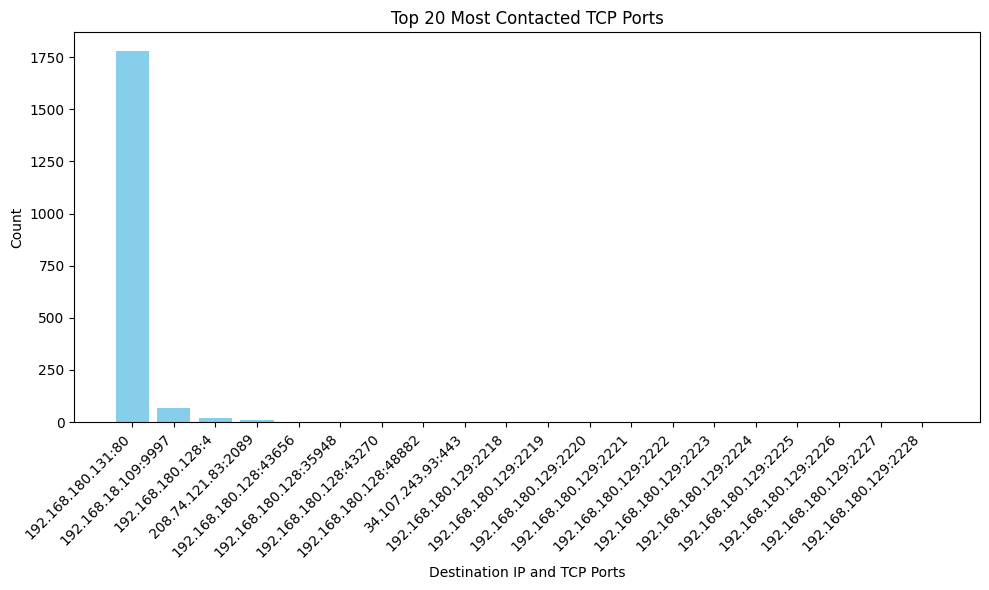

In [ ]:
import matplotlib.pyplot as plt
from scapy.all import *

def create_destination_ports_graph(pcap_file):
    packets = rdpcap(pcap_file)

    # Dictionary to store the count of destination ports
    destination_ports = {}

    for packet in packets:
        # Check if the packet has IP and TCP layers
        if IP in packet and TCP in packet:
            dst_ip = packet[IP].dst
            dst_port = packet[TCP].dport

            # Update the count of destination ports
            destination_ports[(dst_ip, dst_port)] = destination_ports.get((dst_ip, dst_port), 0) + 1

    # Sort destination ports based on their count in descending order
    sorted_ports = sorted(destination_ports.items(), key=lambda x: x[1], reverse=True)

    return sorted_ports

def visualize_destination_ports_plot(sorted_ports, top_n=20):
    plt.figure(figsize=(10, 6))

    # Take only the top n destination ports
    top_ports = sorted_ports[:top_n]

    destinations, counts = zip(*top_ports)
    dst_labels = [f"{ip}:{port}" for (ip, port) in destinations]

    plt.bar(dst_labels, counts, color='skyblue')
    plt.xlabel('Destination IP and TCP Ports')
    plt.ylabel('Count')
    plt.title(f'Top {top_n} Most Contacted TCP Ports')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    pcap_file_path = "/content/Hulk.pcap"
    sorted_ports = create_destination_ports_graph(pcap_file_path)
    visualize_destination_ports_plot(sorted_ports, top_n=20)